Model performance is tested best when it is tasked to distinguish between "similar" objects. So I have tried to create some clusters of objects which are similar to one another. The number in parentheses is the label index.

**Round things**
- baseball (19), basketball (22), soccer ball (276), wheel (337), cookie (81), donut (96), moon (190), clock (76), pizza (228)

**Drinkware & containers**
- cup (90), mug (197), coffee cup (78), wine glass (340), vase (331), wine bottle (339), teapot (306)

**Slender handhelds & utensils (long thin stems + tip variations)**
- pencil (220), marker (183), toothbrush (317), screwdriver (257), fork (127), knife (166)

**Road vehicles (boxy cabins + wheels)**
- car (64), truck (326), pickup truck (223), bus (50), school bus (254), van (330)

**Watercraft (hulls/superstructure silhouettes)**
- sailboat (250), speedboat (278), canoe (63), cruise ship (89)

**Boxy appliances (rectangular)**
- microwave (188), oven (206), toaster (313), dishwasher (92), washing machine (333)

**Furniture**
- chair (71), couch (83), bed (28), bench (31), table (305)

**Apparel (necklines/hems/sleeves are subtle and often omitted)**
- t-shirt (304), sweater (300), jacket (160), pants (212), shorts (263)

**Pure shape/sign confusion (polygon sides vs labeled sign)**
- circle (74), octagon (203), stop sign (291)

#### Imports

In [1]:
import json
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

### Using the same dataloader pipeline as used in training

### Global Variables

In [2]:
# Files
LABELS_JSON    = "/home/priyanka/doodle-vision/training/dataset/label_map.json"
PROCESSED_DATA_DIR = "/home/priyanka/doodle-vision/training/dataset/processed"

# Data props
NUM_CLASSES = 345

# Training
SAMPLES_PER_CLASS = 3_000
SPLIT_RATIOS = (0.8, 0.1, 0.1) # train, val, test
BATCH_SIZE = 512

# Confusion Matrix
CONFUSING_LABELS_MAP = {
    "round": [19, 22, 276, 337, 81, 96, 190, 76, 228],
    "drinkware": [90, 197, 78, 340, 331, 339, 306],
    "slender": [220, 183, 317, 257, 127, 166],
    "vehicles": [64, 326, 223, 50, 254, 330],
    "watercraft": [250, 278, 63, 89],
    "appliances": [188, 206, 313, 92, 333],
    "furniture": [71, 83, 28, 31, 305],
    "apparel": [304, 300, 160, 212, 263],
    "shapes": [74, 203, 291],
}

In [3]:
with open(LABELS_JSON, 'r') as f:
    LABEL_MAP = json.load(f)

REV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

In [4]:
FILTERED_LABEL_MAP = {}
for group, ids in CONFUSING_LABELS_MAP.items():
    FILTERED_LABEL_MAP[group] = {REV_LABEL_MAP[i]: i for i in ids if i in REV_LABEL_MAP}

### Disk Data Loader for Original Data

In [5]:
# Using the individual + in-memory mode for tflite inference
images = []
strokes = []

# Always list of integers
labels = []

for group, label_map in tqdm(FILTERED_LABEL_MAP.items(), desc="Building dataset"):
    for cls, label in tqdm(label_map.items(), desc=f"Building {group}"):
        image_files = sorted(
            glob(os.path.join(PROCESSED_DATA_DIR, "images", cls, "*.npy"))
        )
        stroke_files = sorted(
            glob(os.path.join(PROCESSED_DATA_DIR, "strokes", cls, "*.npy"))
        )

        N = min(len(image_files), len(stroke_files), SAMPLES_PER_CLASS)

        for i in range(N):
            image_path = image_files[i]
            stroke_path = stroke_files[i]

            images.append(np.load(image_path))
            strokes.append(np.load(stroke_path))
            labels.append(label)

print(f"[In-Memory Mode] Loaded {len(labels):,} samples.")


Building dataset: 100%|██████████| 9/9 [00:20<00:00,  2.33s/it]

[In-Memory Mode] Loaded 150,000 samples.


In [6]:
def data_generator(images, strokes, labels):
    for image, stroke, label in zip(images, strokes, labels):
        yield (
            image,
            stroke,
            tf.one_hot(label, depth=NUM_CLASSES),
        )

In [7]:
def format_sample(img, stroke, label):
    return {"stroke_input": stroke, "image_input": img}, label

output_signature = (
    tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(130, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.int32),
)

In [8]:
def build_dataset(images, strokes, labels, is_shuffle=False):
    def gen():
        return data_generator(images, strokes, labels)

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature
    )

    if is_shuffle:
        ds = ds.shuffle(BATCH_SIZE * 10)

    ds = ds.map(format_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    return ds.prefetch(tf.data.AUTOTUNE)

In [9]:
ds = build_dataset(images, strokes, labels)

I0000 00:00:1755683104.598958  213381 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19649 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


### Load the Model

In [10]:
model = tf.keras.models.load_model('/home/priyanka/doodle-vision/training/best_model_345_classes_30000_examples.keras')

### Run Predictions

In [11]:
# Get predictions
y_pred_probs = model.predict(ds, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(labels)

293/293 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step


/home/priyanka/doodle-vision/.tens-and-cuda/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


### Plot Confusion Matrix

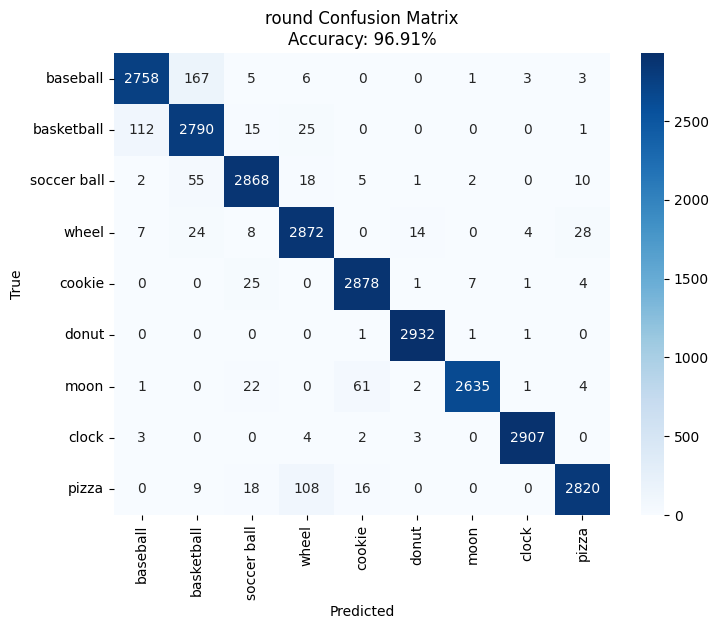

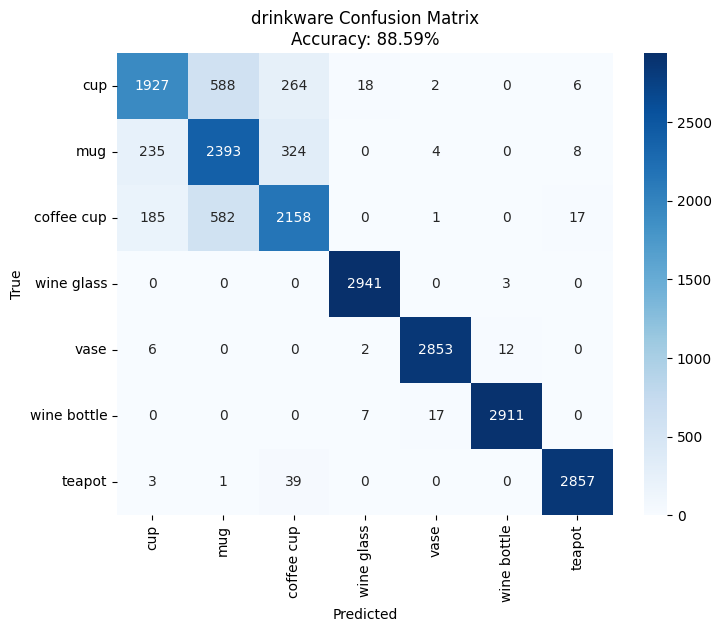

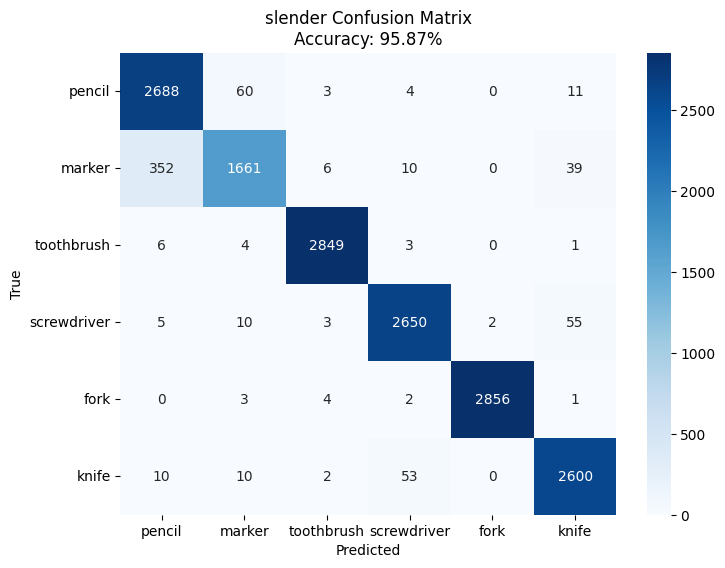

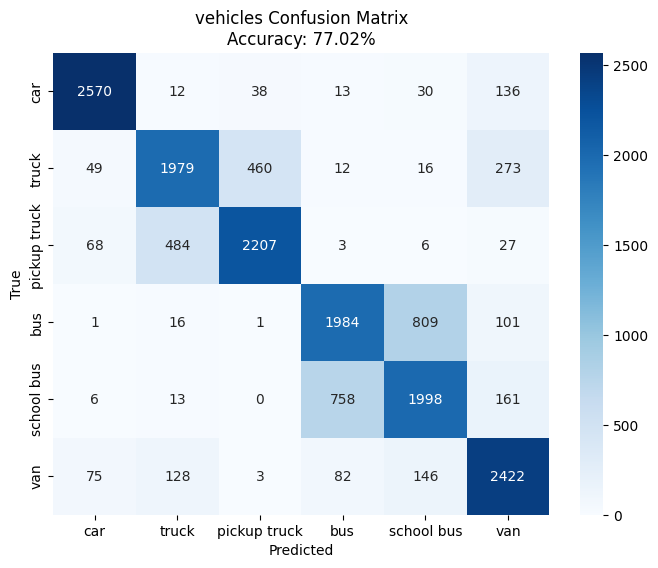

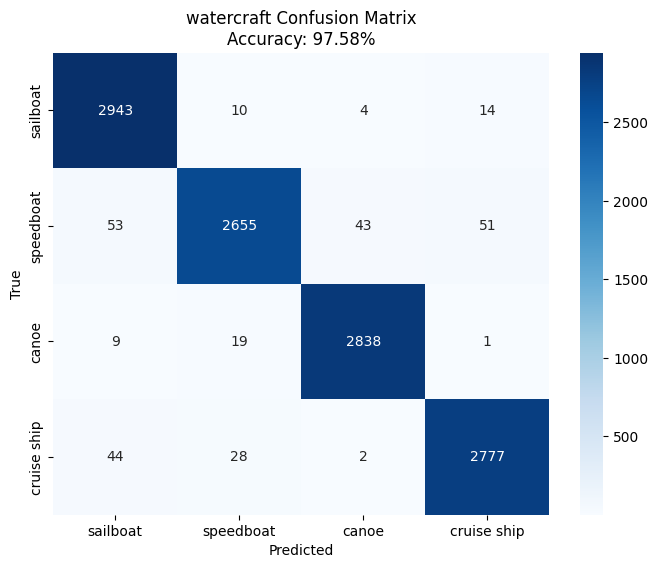

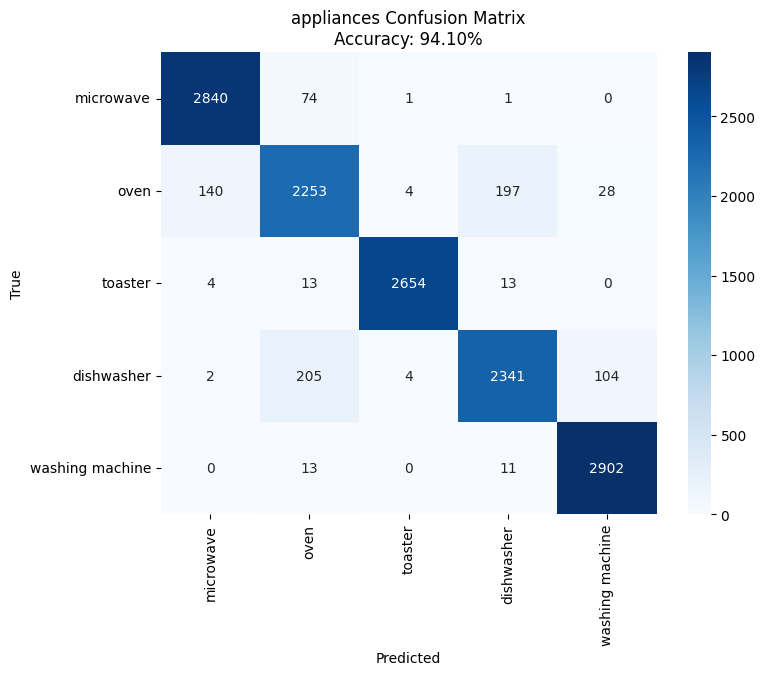

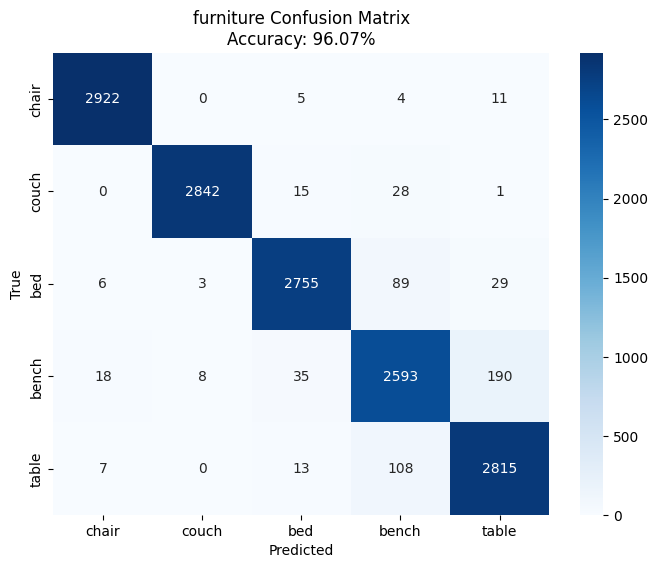

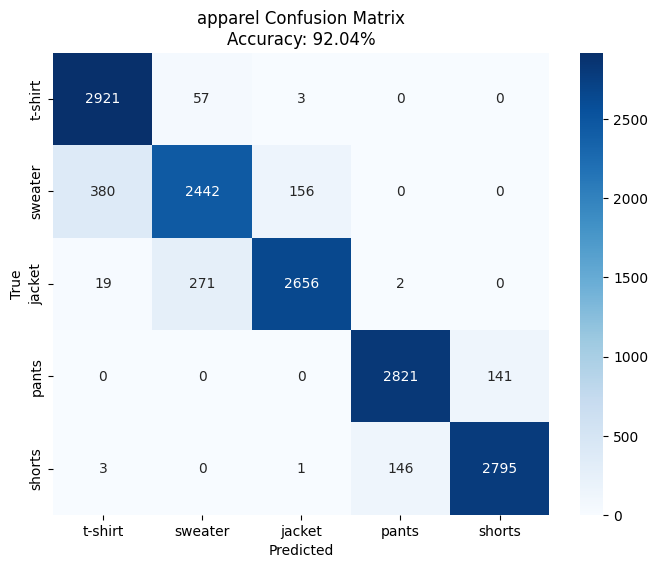

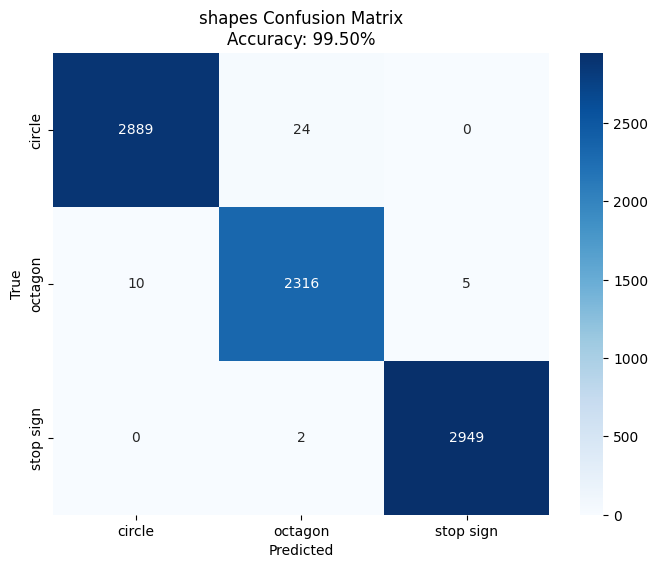

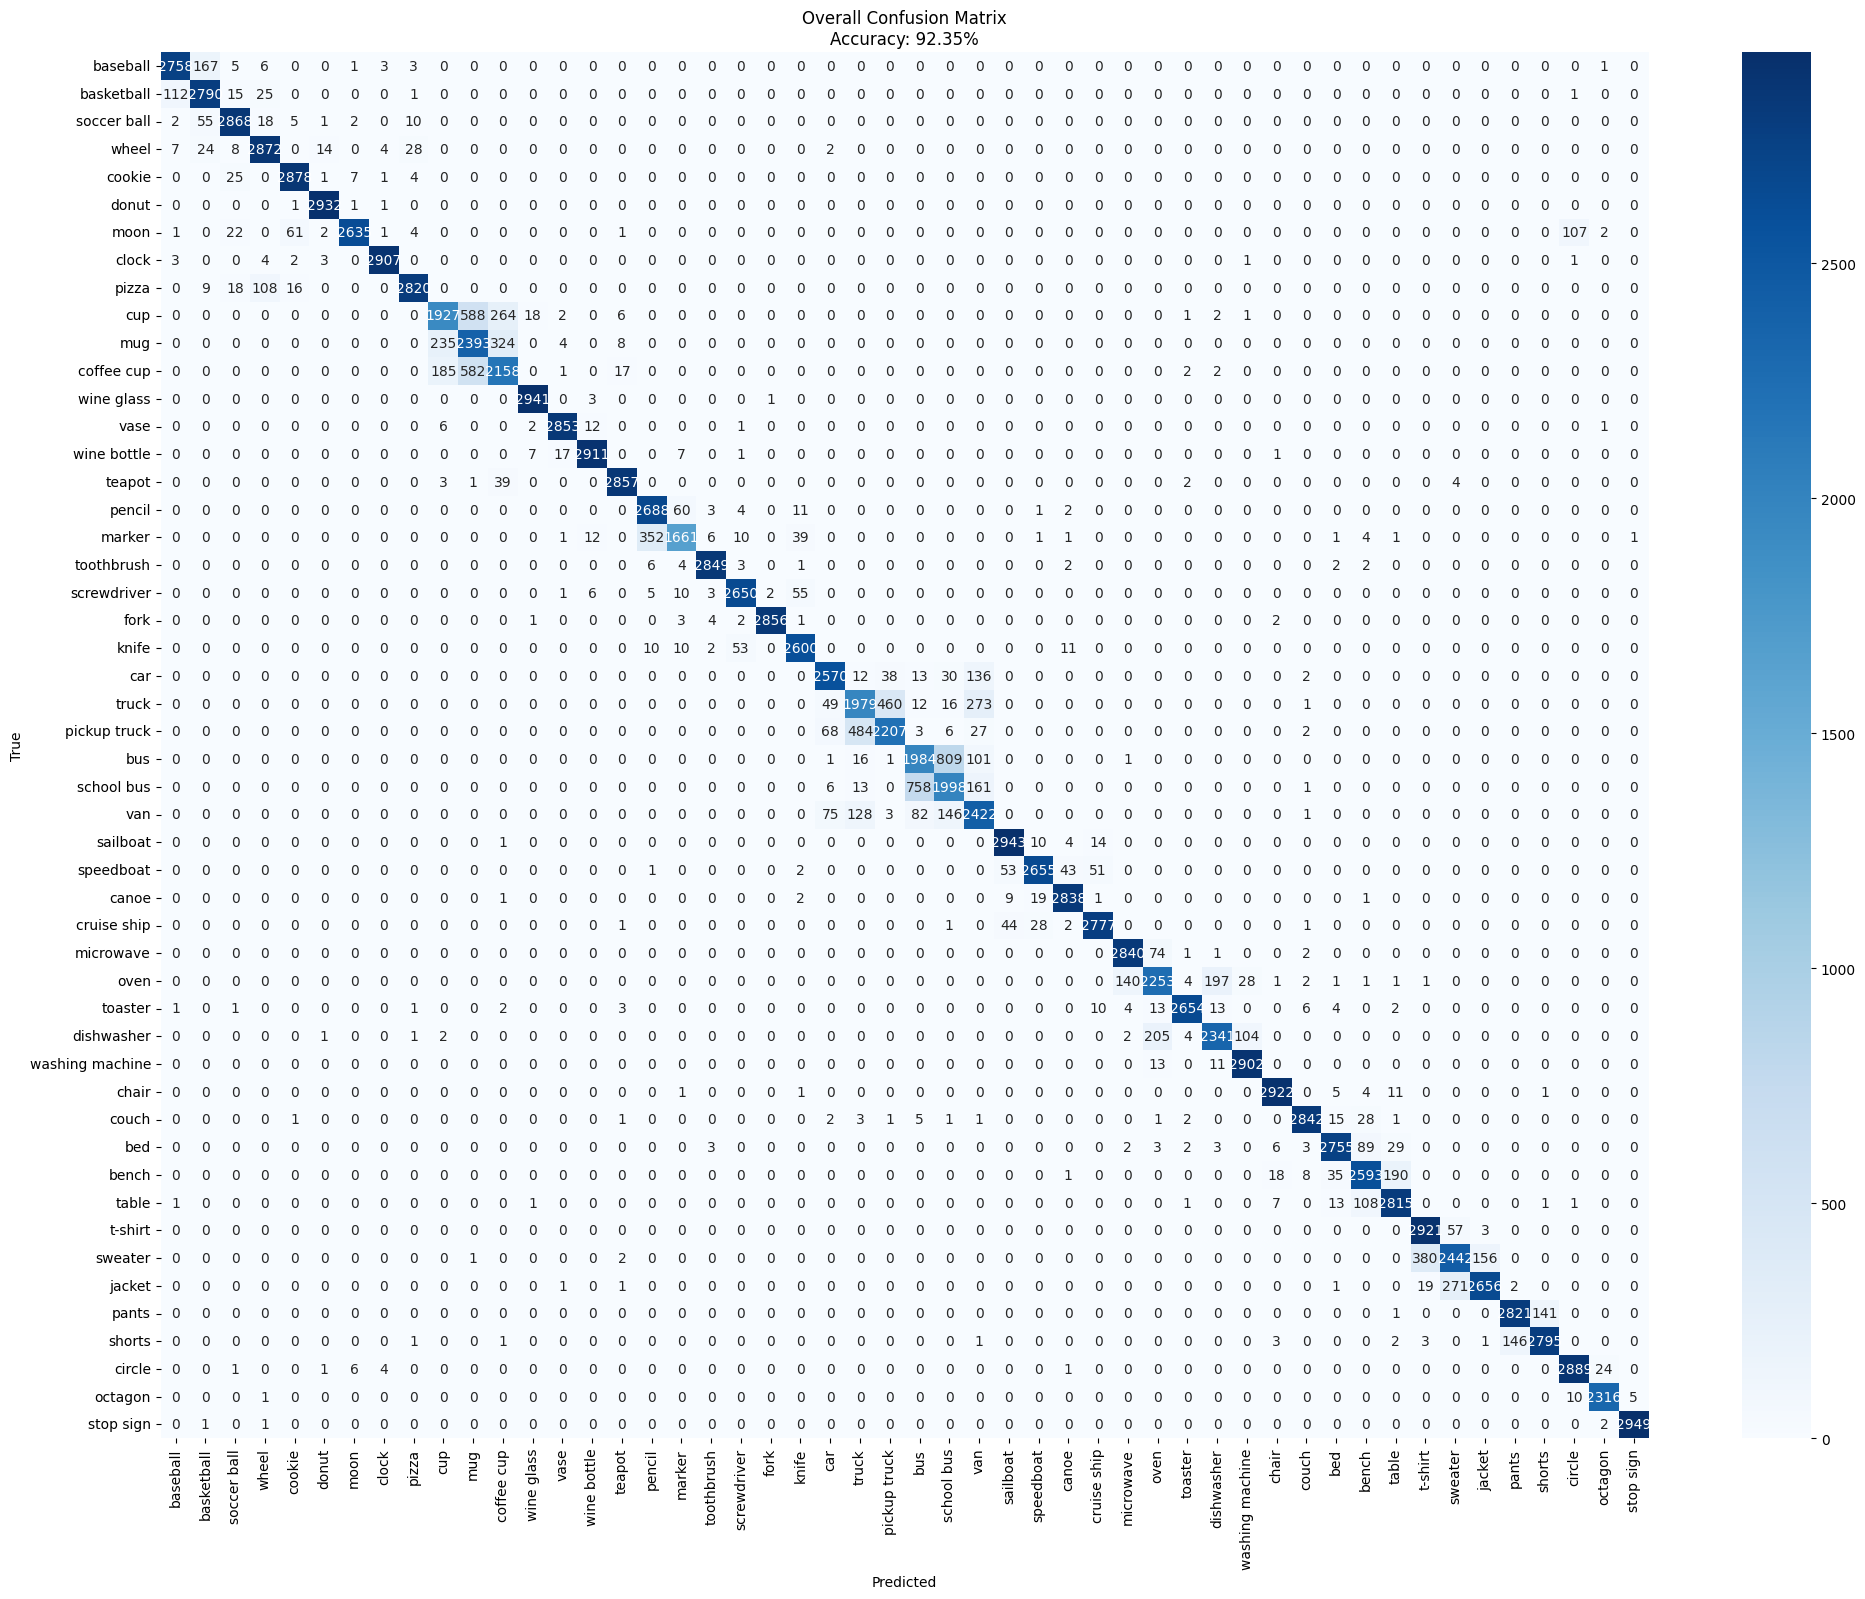

In [ ]:
def plot_confusion_matrix(
    y_true, y_pred, class_ids, class_names, title, figsize=(8, 6)
):
    cm = confusion_matrix(y_true, y_pred, labels=class_ids)
    accuracy = np.trace(cm) / np.sum(cm)
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=class_names,
        yticklabels=class_names,
        cmap="Blues",
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{title}\nAccuracy: {accuracy:.2%}")  
    plt.show()


# Category-specific CMs
class_names_50 = []
class_ids_50 = []
for group, label_map in FILTERED_LABEL_MAP.items():
    class_names = list(label_map.keys())
    class_ids = list(label_map.values())

    class_names_50.extend(class_names)
    class_ids_50.extend(class_ids)

    mask = np.isin(y_true, class_ids)

    y_true_group = y_true[mask]
    y_pred_group = y_pred[mask]

    plot_confusion_matrix(y_true_group, y_pred_group, class_ids, class_names, f"{group} Confusion Matrix")

# Global (50 classes) confusion matrix
mask_50 = np.isin(y_true, class_ids_50)

y_true_50 = y_true[mask_50]
y_pred_50 = y_pred[mask_50]

plot_confusion_matrix(
    y_true_50,
    y_pred_50,
    class_ids_50,
    class_names_50,
    "Overall Confusion Matrix",
    figsize=(24, 18),
)
